In [2]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
from scipy.stats import chisquare
import scipy
from scipy.fft import fft, ifft
from scipy.signal import convolve as conv

In [127]:
channel = 6 #Canale di cui si effettua l'analisi

#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.25, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -50, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]
print(Vt, Q_max, Q_min)

-1.25 -50 -1000


In [132]:
PATH = '../Dati/Run_ch6_Cs_Measurements_Only_3_27_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Run_ch6_X_Measurements_Only_3_26_2024.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

#Estrazione dati da file 

chargeCsT = np.array(RunCs['tree'].arrays()['charge'])
ampCsT = np.array(RunCs['tree'].arrays()['amp'])

chargeNT = np.array(RunNoise['tree'].arrays()['charge'])
ampNT= np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

print("eventi segnale+rumore", evCsT)
print("eventi rumore", evNT)

eventi segnale+rumore 1000000
eventi rumore 300000


In [140]:
trueCs = ampCsT>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCsT[trueCs]
ampCs=ampCsT[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampNT>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeNT[trueX]
ampN=ampNT[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 6 = 847899
#Noise ripulita su ch 6 = 218713


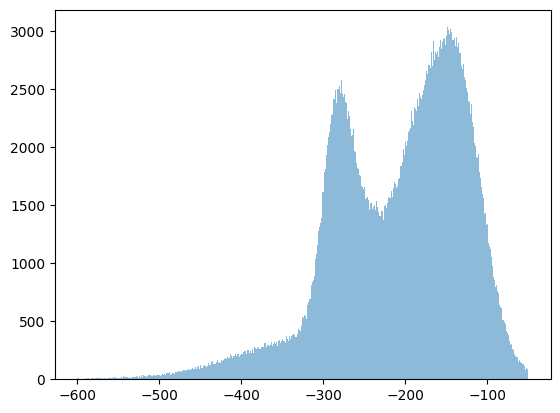

517743.9611816406


In [151]:
bin=900
binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), 
                            density = False, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)
norm=np.sum(binCs)
plt.show()
err=np.sqrt(binCs)/(np.sum(binCs)*(edgeCs[1]-edgeCs[0]))

print((np.sum(binCs)*(edgeCs[1]-edgeCs[0])))


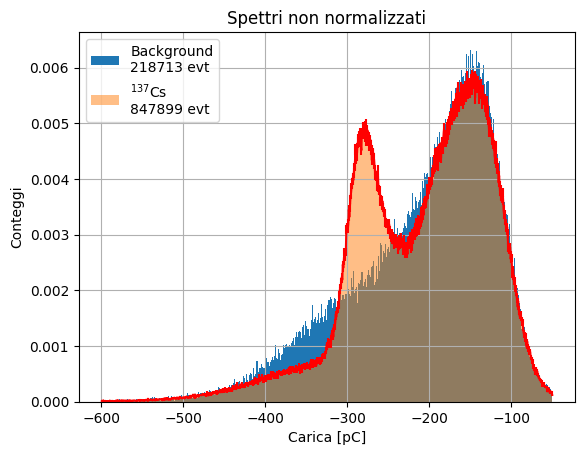

In [152]:
bin = 900 #Binnaggio scelto?

is_density=True


binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-600, Q_max), 
                           density = is_density, label = "Background\n" + str(len(chargeN)) + " evt")

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), 
                            density = is_density, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)






trash = plt.errorbar(edgeCs[1:], binCs,err, color='r')

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.show()



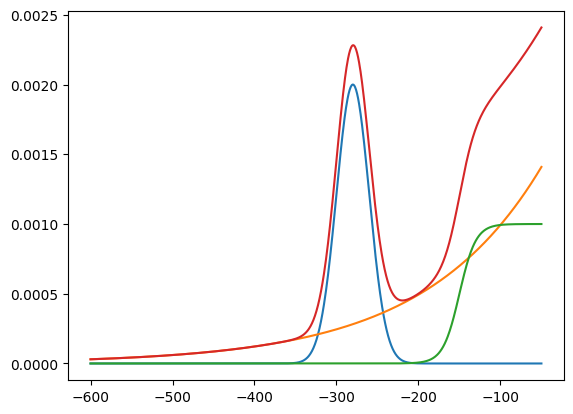

In [153]:
def Spectrum_Shape(x, Cg, mu, sigma, Ce, b, x0, Cf, A, x1, c):
     return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*np.exp(b*x-x0) + c + Cf*(1/(1 + np.exp(x1-A*x)))

#print(edgeCs)
#print(Spectrum_Shape(edgeCs, 2000, -280, 20,    2000,0.05 ,-4000 ,    10000, 0.05, -4000 , 0))
x=np.arange(-5, 5, len(edgeCs))
Cg=0.002
mu=-280
sigma=20
plt.plot(edgeCs, Cg* np.exp(- (edgeCs- mu)**2/ (2 * sigma**2)))
Ce=0.002
b=0.007
x0=0
plt.plot(edgeCs, Ce*np.exp(b*edgeCs-x0))
Cf=0.001
A=0.1
x1=-15
plt.plot(edgeCs, Cf*(1/(1 + np.exp(x1-A*edgeCs))))
c=0
plt.plot(edgeCs, Cg* np.exp(- (edgeCs- mu)**2/ (2 * sigma**2))+ Ce*np.exp(b*edgeCs-x0) + Cf*(1/(1 + np.exp(x1-A*edgeCs))))
#plt.plot(edgeCs, Spectrum_Shape(edgeCs, Cg, mu, sigma, Ce, b, x0, Cf, A, x1, c))

In [150]:
print(len(binCs))

200


[ 3.49497490e-03 -2.81894129e+02  1.98299022e+01  5.69389998e-03
  3.50110746e-03 -1.18903949e+00  5.64345205e-04  1.94701612e-01
 -3.86182529e+01 -5.66925905e-03]


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_54704/1210577118.py:2: RuntimeWarning: overflow encountered in exp
  return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*np.exp(b*x-x0) + c + Cf*(1/(1 + np.exp(x1-A*x)))


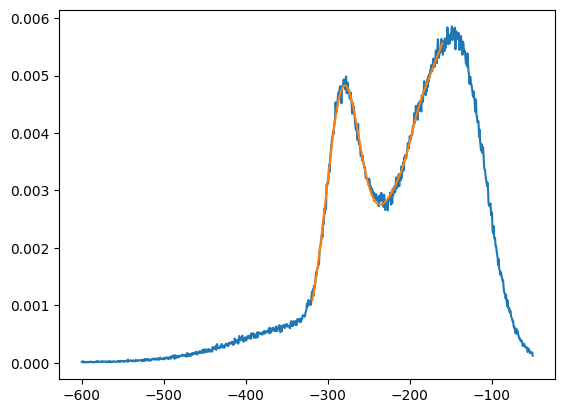

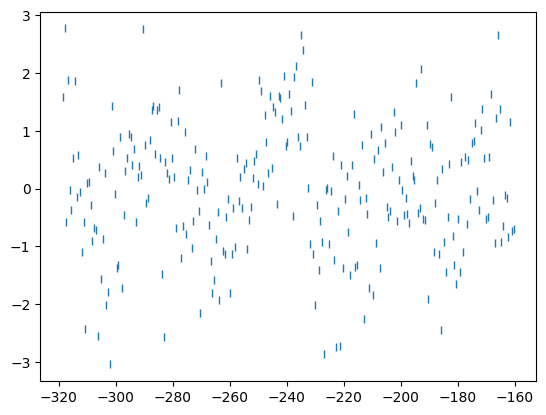

In [155]:
bin_centers=np.convolve(edgeCs , [0.5, 0.5], "valid")
start=460
stop=720
popt, pcov = curve_fit(Spectrum_Shape, bin_centers[start:stop], binCs[start:stop], p0=[Cg, mu, sigma, Ce, b, x0, Cf, A, x1, c],  maxfev = 8000)
print(popt)
plt.plot(bin_centers, binCs)
fit=Spectrum_Shape(bin_centers[start:stop], *popt)
plt.plot(bin_centers[start:stop], fit)
plt.show()

residues=((binCs[start:stop]-fit)/err[start:stop])
plt.plot(bin_centers[start:stop], residues, '|')

In [56]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel

In [57]:
# Define the shifted exponential function
def shifted_exponential(x, amp, decay, shift):
    return amp * np.exp(-(x - shift) / decay)

In [58]:
# Create an lmfit Model using the custom function
sh_exp = Model(shifted_exponential)
gauss1 = GaussianModel(prefix='g1_')

# Set initial parameter values and bounds
params = sh_exp.make_params(amp = 1, decay = -10, shift = 1)
params['amp'].min = 0  # Ensure amplitude is positive
params['decay'].max = 0  # Ensure decay rate is negative

params.update(gauss1.make_params(center=dict(value=-350, min=-450, max=-250),
                               sigma=dict(value=50, min=0),
                               amplitude=dict(value=20, min=0)))

model = sh_exp + gauss1

# Fit the model to the data
result = model.fit(binN, params, x = centersN)

# Print fit statistics and parameter values
print(result.fit_report())

# Plot the data and the fitted model
#plt.plot(, y_noisy, 'bo', label='Data')
plt.plot(centersN, result.best_fit, 'r-', label='Fit')
_ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5, label = "Data")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

NameError: name 'centersN' is not defined